In [1]:
import pandas as pd
from encode_desc import transform_description, tokenize_description

### Pre-model training

#### Load data

In [2]:
df_test = pd.read_pickle("./c_test_V2.1.pkl")
df_test["set"] = 'test'
df = pd.read_pickle("./c_train_V2.1.pkl")
df["set"] = 'train'
print(len(df))
df = pd.concat([df, df_test])
print(len(df))
df.sample(10)

309
387


,index,vote_id,description,votes,votes_by_party,vote_caller,url,description_text,date,y_pred,set
2,1544,"Afstemning nr. 163, 2009-10","[Sagsgang:, Fremsat 21-10-2009, 1. behandlet /...","{'party': ['Liberal Alliance (LA)', 'Dansk Fol...","{'Absent': ['19', '19', '9', '9', '7', '5', '3...","[Indenrigs- og socialminister, Karen Ellemann ...",https://www.ft.dk//samling/20091/afstemning/16...,"Loven har to formål, dels at øge boligejeres i...",2009-12-27,climate,test
68,3982,"Afstemning nr. 199, 2017-18","[Fremsat:, 23-01-2018, Forslag til vedtagelse:...",{'party': ['Uden for folketingsgrupperne (UFG)...,"{'Absent': ['17', '14', '16', '5', '5', '4', '...","[Jens Joel (S), Maria Reumert Gjerding (EL), C...",https://www.ft.dk//samling/20171/afstemning/19...,"Folketinget ønsker, at Danmark er ambitiøs i k...",2018-01-23,climate,train
6,1702,"Afstemning nr. 338, 2009-10","[Sagsgang:, Fremsat 25-02-2010, 1. behandlet /...","{'party': ['Liberal Alliance (LA)', 'Dansk Fol...","{'Absent': ['17', '16', '8', '10', '8', '5', '...","[Transportminister, Hans Christian Schmidt (V)]",https://www.ft.dk//samling/20091/afstemning/33...,"Formålet med loven er, at der anlægges en ny d...",2010-05-26,climate,train
11,3692,"Afstemning nr. 253, 2016-17","[Fremsat:, 18-04-2017, Forslag til vedtagelse:...",{'party': ['Uden for folketingsgrupperne (UFG)...,"{'Absent': ['17', '13', '13', '5', '5', '4', '...",[Mikkel Dencker (DF)],https://www.ft.dk//samling/20161/afstemning/25...,"Folketinget konstaterer, at der i december 201...",2017-04-18,climate,train
211,3879,"Afstemning nr. 16, 2017-18","[Sagsgang:, Fremsat 04-10-2017, 1. behandlet /...",{'party': ['Uden for folketingsgrupperne (UFG)...,"{'Absent': ['18', '15', '16', '5', '5', '4', '...","[Energi-, forsynings- og klimaminister, Lars C...",https://www.ft.dk//samling/20171/afstemning/16...,"Lovforslaget forbedrer muligheden for, at kulb...",2017-12-05,climate,train
198,3198,"Afstemning nr. 370, 2014-15 (1. samling)","[Sagsgang:, Fremsat 25-03-2015, 1. behandlet /...","{'party': ['Dansk Folkeparti (DF)', 'Liberal A...","{'Absent': ['20', '20', '9', '6', '4', '4', '4...","[Klima-, energi- og bygningsminister, Rasmus H...",https://www.ft.dk//samling/20141/afstemning/37...,"Lovforslaget bemyndiger klima-, energi- og byg...",2015-06-01,climate,train
204,796,"Afstemning nr. 427, 2006-07","[Sagsgang:, Fremsat 09-01-2007, 1. behandlet/h...","{'party': ['Det Konservative Folkeparti (KF)',...","{'Absent': ['21', '20', '7', '6', '7', '4', '4...","[Morten Homann (SF), Poul Henrik Hedeboe (SF),...",https://www.ft.dk//samling/20061/afstemning/42...,Hensigten med beslutningsforslaget var at pålæ...,2007-05-25,climate,train
279,5032,"Afstemning nr. 143, 2020-21","[Sagsgang:, Fremsat 12-11-2020, 1. behandlet /...","{'party': ['Siumut (SIU)', 'Dansk Folkeparti (...","{'Absent': ['18', '18', '8', '7', '7', '6', '6...","[Miljøminister, Lea Wermelin (S)]",https://www.ft.dk//samling/20201/afstemning/14...,Forslaget sætter rammerne for Den Danske Klima...,2020-12-29,climate,train
178,4677,"Afstemning nr. 240, 2019-20","[Sagsgang:, Fremsat 04-12-2019, 1. behandlet /...","{'party': ['Siumut (SIU)', 'Liberal Alliance (...","{'Absent': ['18', '16', '5', '6', '5', '5', '5...","[Skatteminister, Morten Bødskov (S)]",https://www.ft.dk//samling/20191/afstemning/24...,Formålet med lovforslaget er at omlægge regler...,2020-02-25,climate,train
228,4978,"Afstemning nr. 257, 2020-21","[Fremsat:, 21-12-2020, Forslag til vedtagelse:...","{'party': ['Siumut (SIU)', 'Dansk Folkeparti (...","{'Absent': ['22', '18', '8', '7', '7', '6', '6...",[Morten Messerschmidt (DF)],https://www.ft.dk//samling/20201/afstemning/25...,"Folketinget understreger, at den grønne omstil...",2020-12-21,climate,train


In [3]:

print(len(df))
df = df.drop_duplicates(subset='description_text').reset_index(drop=True)
df = df.drop(columns=["index"])
df["vote_caller"] = df["vote_caller"].astype(str)
print(len(df))
df.head(5)

387
387


,vote_id,description,votes,votes_by_party,vote_caller,url,description_text,date,y_pred,set
0,"Afstemning nr. 6, 2016-17","[Sagsgang:, Fremsat 05-10-2016, 1. behandlet/h...",{'party': ['Uden for folketingsgrupperne (UFG)...,"{'Absent': ['16', '14', '16', '5', '5', '4', '...","['Energi-, forsynings- og klimaminister' 'Lars...",https://www.ft.dk//samling/20161/afstemning/6.htm,Med beslutningsforslaget giver Folketinget sit...,2016-10-27,climate,train
1,"Afstemning nr. 52, 2021-22","[Sagsgang:, Fremsat 06-10-2021, 1. behandlet /...","{'party': ['Siumut (SIU)', 'Dansk Folkeparti (...","{'Absent': ['20', '15', '6', '6', '5', '6', '5...","['Klima-, energi- og forsyningsminister' 'Dan ...",https://www.ft.dk//samling/20211/afstemning/52...,Lovforslaget gennemfører fjernkølingsinitiativ...,2021-12-14,climate,train
2,"Afstemning nr. 277, 2013-14","[Fremsat:, 02-06-2014, Forslag til vedtagelse:...","{'party': ['Dansk Folkeparti (DF)', 'Liberal A...","{'Absent': ['15', '20', '9', '7', '4', '4', '4...",['Steen Gade (SF)' 'Lars Christian Lilleholt (...,https://www.ft.dk//samling/20131/afstemning/27...,Folketinget tager Energipolitisk Redegørelse 2...,2014-06-02,climate,train
3,"Afstemning nr. 7, 2009-10","[Fremsat:, 06-11-2009, Forslag til vedtagelse:...","{'party': ['Liberal Alliance (LA)', 'Dansk Fol...","{'Absent': ['16', '17', '8', '7', '7', '4', '2...",['Jeppe Kofod (S)' 'Lars Christian Lilleholt (...,https://www.ft.dk//samling/20091/afstemning/7.htm,Regeringen opfordres til at udarbejde en redeg...,2009-11-06,climate,train
4,"Afstemning nr. 261, 2015-16","[Sagsgang:, Fremsat 16-12-2015, 1. behandlet /...","{'party': ['Siumut (SIU)', 'Dansk Folkeparti (...","{'Absent': ['18', '15', '13', '5', '5', '3', '...","['Energi-, forsynings- og klimaminister' 'Lars...",https://www.ft.dk//samling/20151/afstemning/26...,Lovforslagets formål at udmønte et forlig om e...,2016-02-16,climate,train


In [4]:
# Uncomment if only want to run on smaller sample
#df = df.sample(60, random_state=42).reset_index(drop=True)

#### Tokenize vote-summaries

In [5]:
df_tokenized = tokenize_description(df, "Venstre", "../BL/models_binary_party/", True)
print(len(df_tokenized))
df_tokenized.head(3)

Loading tokenizer ...
Tokenizing all description texts ...


100%|██████████| 1/1 [00:01<00:00,  1.32s/ba]

Tokenizing all description texts completed!
387


,vote_id,description,votes,votes_by_party,vote_caller,url,description_text,date,y_pred,set,input_ids,token_type_ids,attention_mask
0,"Afstemning nr. 6, 2016-17","[Sagsgang:, Fremsat 05-10-2016, 1. behandlet/h...",{'party': ['Uden for folketingsgrupperne (UFG)...,"{'Absent': ['16', '14', '16', '5', '5', '4', '...","['Energi-, forsynings- og klimaminister' 'Lars...",https://www.ft.dk//samling/20161/afstemning/6.htm,Med beslutningsforslaget giver Folketinget sit...,2016-10-27,climate,train,"[2, 61, 14165, 8570, 629, 8320, 747, 7284, 45,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"Afstemning nr. 52, 2021-22","[Sagsgang:, Fremsat 06-10-2021, 1. behandlet /...","{'party': ['Siumut (SIU)', 'Dansk Folkeparti (...","{'Absent': ['20', '15', '6', '6', '5', '6', '5...","['Klima-, energi- og forsyningsminister' 'Dan ...",https://www.ft.dk//samling/20211/afstemning/52...,Lovforslaget gennemfører fjernkølingsinitiativ...,2021-12-14,climate,train,"[2, 12335, 12672, 2624, 20599, 12169, 2884, 50...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"Afstemning nr. 277, 2013-14","[Fremsat:, 02-06-2014, Forslag til vedtagelse:...","{'party': ['Dansk Folkeparti (DF)', 'Liberal A...","{'Absent': ['15', '20', '9', '7', '4', '4', '4...",['Steen Gade (SF)' 'Lars Christian Lilleholt (...,https://www.ft.dk//samling/20131/afstemning/27...,Folketinget tager Energipolitisk Redegørelse 2...,2014-06-02,climate,train,"[2, 8320, 883, 1844, 23337, 11073, 2637, 45, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


#### Transformation (party probs)
transform tokenized vote-summaries into party probs (for the 9 chosen parties)

In [6]:
parties = ["Alternativet", "Dansk Folkeparti", "Det Konservative Folkeparti", "Det Radikale Venstre", "Enhedslisten", "Liberal Alliance", "Socialdemokratiet", "Socialistisk Folkeparti" ,"Venstre"]
df_trans = df_tokenized
for party in parties:
    df_trans = transform_description(df_trans, party, "../../../../Models/binary/", 2, True)

df_trans.head(3)
## On GPU Jonathan PC 2 30s per party

Loading model for Alternativet ...


***** Running Prediction *****
  Num examples = 387
  Batch size = 8


Transforming all tokenized texts for Alternativet ...


100%|██████████| 49/49 [00:28<00:00,  1.70it/s]
loading configuration file ../../../../Models/binary/Dansk Folkeparti\config.json
Model config BertConfig {
  "_name_or_path": "Maltehb/danish-bert-botxo",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version":

Transforming all tokenized texts for Alternativet completed!
Loading model for Dansk Folkeparti ...


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at ../../../../Models/binary/Dansk Folkeparti.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 387
  Batch size = 8


Transforming all tokenized texts for Dansk Folkeparti ...


100%|██████████| 49/49 [00:29<00:00,  1.68it/s]
loading configuration file ../../../../Models/binary/Det Konservative Folkeparti\config.json
Model config BertConfig {
  "_name_or_path": "Maltehb/danish-bert-botxo",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformer

Transforming all tokenized texts for Dansk Folkeparti completed!
Loading model for Det Konservative Folkeparti ...


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at ../../../../Models/binary/Det Konservative Folkeparti.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 387
  Batch size = 8


Transforming all tokenized texts for Det Konservative Folkeparti ...


100%|██████████| 49/49 [00:29<00:00,  1.67it/s]
loading configuration file ../../../../Models/binary/Det Radikale Venstre\config.json
Model config BertConfig {
  "_name_or_path": "Maltehb/danish-bert-botxo",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_versi

Transforming all tokenized texts for Det Konservative Folkeparti completed!
Loading model for Det Radikale Venstre ...


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at ../../../../Models/binary/Det Radikale Venstre.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 387
  Batch size = 8


Transforming all tokenized texts for Det Radikale Venstre ...


100%|██████████| 49/49 [00:29<00:00,  1.67it/s]
loading configuration file ../../../../Models/binary/Enhedslisten\config.json
Model config BertConfig {
  "_name_or_path": "Maltehb/danish-bert-botxo",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.

Transforming all tokenized texts for Det Radikale Venstre completed!
Loading model for Enhedslisten ...


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at ../../../../Models/binary/Enhedslisten.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 387
  Batch size = 8


Transforming all tokenized texts for Enhedslisten ...


100%|██████████| 49/49 [00:29<00:00,  1.68it/s]
loading configuration file ../../../../Models/binary/Liberal Alliance\config.json
Model config BertConfig {
  "_name_or_path": "Maltehb/danish-bert-botxo",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version":

Transforming all tokenized texts for Enhedslisten completed!
Loading model for Liberal Alliance ...


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at ../../../../Models/binary/Liberal Alliance.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 387
  Batch size = 8


Transforming all tokenized texts for Liberal Alliance ...


100%|██████████| 49/49 [00:29<00:00,  1.68it/s]
loading configuration file ../../../../Models/binary/Socialdemokratiet\config.json
Model config BertConfig {
  "_name_or_path": "Maltehb/danish-bert-botxo",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version"

Transforming all tokenized texts for Liberal Alliance completed!
Loading model for Socialdemokratiet ...


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at ../../../../Models/binary/Socialdemokratiet.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 387
  Batch size = 8


Transforming all tokenized texts for Socialdemokratiet ...


100%|██████████| 49/49 [00:29<00:00,  1.66it/s]
loading configuration file ../../../../Models/binary/Socialistisk Folkeparti\config.json
Model config BertConfig {
  "_name_or_path": "Maltehb/danish-bert-botxo",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_ve

Transforming all tokenized texts for Socialdemokratiet completed!
Loading model for Socialistisk Folkeparti ...


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at ../../../../Models/binary/Socialistisk Folkeparti.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 387
  Batch size = 8


Transforming all tokenized texts for Socialistisk Folkeparti ...


100%|██████████| 49/49 [00:29<00:00,  1.66it/s]
loading configuration file ../../../../Models/binary/Venstre\config.json
Model config BertConfig {
  "_name_or_path": "Maltehb/danish-bert-botxo",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.17.0"

Transforming all tokenized texts for Socialistisk Folkeparti completed!
Loading model for Venstre ...


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at ../../../../Models/binary/Venstre.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 387
  Batch size = 8


Transforming all tokenized texts for Venstre ...


100%|██████████| 49/49 [00:29<00:00,  1.66it/s]

Transforming all tokenized texts for Venstre completed!


,vote_id,description,votes,votes_by_party,vote_caller,url,description_text,date,y_pred,set,...,Enhedslisten_weight_for,Enhedslisten_weight_against,Liberal Alliance_weight_for,Liberal Alliance_weight_against,Socialdemokratiet_weight_for,Socialdemokratiet_weight_against,Socialistisk Folkeparti_weight_for,Socialistisk Folkeparti_weight_against,Venstre_weight_for,Venstre_weight_against
0,"Afstemning nr. 6, 2016-17","[Sagsgang:, Fremsat 05-10-2016, 1. behandlet/h...",{'party': ['Uden for folketingsgrupperne (UFG)...,"{'Absent': ['16', '14', '16', '5', '5', '4', '...","['Energi-, forsynings- og klimaminister' 'Lars...",https://www.ft.dk//samling/20161/afstemning/6.htm,Med beslutningsforslaget giver Folketinget sit...,2016-10-27,climate,train,...,0.028648,0.971352,0.635476,0.364524,0.705487,0.294513,0.068693,0.931307,0.043417,0.956583
1,"Afstemning nr. 52, 2021-22","[Sagsgang:, Fremsat 06-10-2021, 1. behandlet /...","{'party': ['Siumut (SIU)', 'Dansk Folkeparti (...","{'Absent': ['20', '15', '6', '6', '5', '6', '5...","['Klima-, energi- og forsyningsminister' 'Dan ...",https://www.ft.dk//samling/20211/afstemning/52...,Lovforslaget gennemfører fjernkølingsinitiativ...,2021-12-14,climate,train,...,0.037614,0.962386,0.195996,0.804004,0.147895,0.852105,0.097172,0.902828,0.034674,0.965326
2,"Afstemning nr. 277, 2013-14","[Fremsat:, 02-06-2014, Forslag til vedtagelse:...","{'party': ['Dansk Folkeparti (DF)', 'Liberal A...","{'Absent': ['15', '20', '9', '7', '4', '4', '4...",['Steen Gade (SF)' 'Lars Christian Lilleholt (...,https://www.ft.dk//samling/20131/afstemning/27...,Folketinget tager Energipolitisk Redegørelse 2...,2014-06-02,climate,train,...,0.112119,0.887881,0.762582,0.237418,0.093539,0.906462,0.082554,0.917446,0.134099,0.865901


In [7]:
df_trans.to_pickle("c_all_w_party_probs_v2.1.pkl")

#### Transformation (Word2Vec embeddings)
add 500d Word2Vec embeddings for vote-summaries

In [8]:
df_trans = pd.read_pickle("./c_all_w_party_probs_v2.1.pkl")
import os
os.chdir("../")

In [9]:
import word_tokenizer
import pandas as pd
from gensim import models

In [10]:
df_trans.head(1)

,vote_id,description,votes,votes_by_party,vote_caller,url,description_text,date,y_pred,set,...,Enhedslisten_weight_for,Enhedslisten_weight_against,Liberal Alliance_weight_for,Liberal Alliance_weight_against,Socialdemokratiet_weight_for,Socialdemokratiet_weight_against,Socialistisk Folkeparti_weight_for,Socialistisk Folkeparti_weight_against,Venstre_weight_for,Venstre_weight_against
0,"Afstemning nr. 6, 2016-17","[Sagsgang:, Fremsat 05-10-2016, 1. behandlet/h...",{'party': ['Uden for folketingsgrupperne (UFG)...,"{'Absent': ['16', '14', '16', '5', '5', '4', '...","['Energi-, forsynings- og klimaminister' 'Lars...",https://www.ft.dk//samling/20161/afstemning/6.htm,Med beslutningsforslaget giver Folketinget sit...,2016-10-27,climate,train,...,0.028648,0.971352,0.635476,0.364524,0.705487,0.294513,0.068693,0.931307,0.043417,0.956583


In [11]:
## Remove stopwords and lemmatize
df_trans['description_filtered'] = df_trans['description_text'].apply(lambda x: word_tokenizer.tokenize(x))

In [12]:
df_trans.head(1)

,vote_id,description,votes,votes_by_party,vote_caller,url,description_text,date,y_pred,set,...,Enhedslisten_weight_against,Liberal Alliance_weight_for,Liberal Alliance_weight_against,Socialdemokratiet_weight_for,Socialdemokratiet_weight_against,Socialistisk Folkeparti_weight_for,Socialistisk Folkeparti_weight_against,Venstre_weight_for,Venstre_weight_against,description_filtered
0,"Afstemning nr. 6, 2016-17","[Sagsgang:, Fremsat 05-10-2016, 1. behandlet/h...",{'party': ['Uden for folketingsgrupperne (UFG)...,"{'Absent': ['16', '14', '16', '5', '5', '4', '...","['Energi-, forsynings- og klimaminister' 'Lars...",https://www.ft.dk//samling/20161/afstemning/6.htm,Med beslutningsforslaget giver Folketinget sit...,2016-10-27,climate,train,...,0.971352,0.635476,0.364524,0.705487,0.294513,0.068693,0.931307,0.043417,0.956583,"[beslutningsforslag, giver, folketing, samtykk..."


In [13]:
## Gustav
#MODEL_FILE = '../dsl_skipgram_2020_m5_f500_epoch2_w5.model/dsl_skipgram_2020_m5_f500_epoch2_w5.model'

## Jonathan
MODEL_FILE = '../../../Models/word2vec/dsl_skipgram_2020_m5_f500_epoch2_w5.models/dsl_skipgram_2020_m5_f500_epoch2_w5.model'
model = models.Word2Vec.load(MODEL_FILE)

## Used for vectorizing the description text (filtered)
words = set(model.wv.index_to_key)

In [14]:
'''def vec_summary(row):
    val = model.wv['start']
    for word in row:
        try:
            val = val + model.wv[word]
        except:
            print(word)
    return val.mean(axis=0)

v0 = vec_summary(df_trans["description_filtered"][0])
v1 = vec_summary(df_trans["description_filtered"][1])'''

'def vec_summary(row):\n    val = model.wv[\'start\']\n    for word in row:\n        try:\n            val = val + model.wv[word]\n        except:\n            print(word)\n    return val.mean(axis=0)\n\nv0 = vec_summary(df_trans["description_filtered"][0])\nv1 = vec_summary(df_trans["description_filtered"][1])'

In [15]:
import numpy as np
X_train_vect = np.array([np.array([model.wv[i] for i in ls if i in words])
                         for ls in df_trans["description_filtered"]])


C:\Users\COBOD\AppData\Local\Temp/ipykernel_13844/1457754460.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_train_vect = np.array([np.array([model.wv[i] for i in ls if i in words])


In [16]:
# Why is the length of the sentence different than the length of the sentence vector?
for i, v in enumerate(X_train_vect):
    print(len(df_trans["description_filtered"].iloc[i]), len(v))


34 32
54 47
57 55
94 81
88 81
107 89
76 68
58 50
58 54
34 30
71 66
65 64
23 20
87 77
43 40
64 58
31 31
25 24
35 33
99 77
95 87
65 51
106 92
109 93
92 87
44 38
86 80
62 56
90 80
49 45
85 70
123 113
48 46
75 65
51 43
33 32
16 16
62 50
55 50
16 15
26 20
47 42
106 98
77 71
22 21
176 152
64 60
68 62
34 31
87 84
51 48
60 58
67 55
79 77
80 75
37 29
98 91
41 38
87 79
38 37
62 55
10 8
108 96
51 48
33 24
63 54
106 93
29 28
91 83
73 68
85 72
23 22
46 44
38 38
36 35
82 76
98 91
44 40
70 67
132 89
52 47
46 44
60 56
54 43
169 142
99 81
71 68
45 40
66 62
79 71
105 89
89 82
48 41
35 31
43 35
77 62
45 42
69 55
131 112
46 43
92 77
76 65
61 55
58 53
43 38
41 35
21 19
30 24
96 91
77 72
64 61
78 70
96 81
95 88
41 38
56 55
64 59
75 64
24 23
61 51
40 35
78 66
71 67
55 53
89 88
86 83
84 80
33 28
88 83
84 78
120 103
38 33
68 64
126 110
23 23
60 54
134 101
18 17
199 164
57 53
145 118
129 126
71 60
26 24
71 57
86 71
44 39
54 46
105 89
23 21
89 86
17 14
95 89
98 90
35 33
24 21
45 41
95 78
83 79
92 85
70 61
95 81


In [17]:
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

In [18]:
# Are our sentence vector lengths consistent?
for i, v in enumerate(X_train_vect_avg):
    print(len(df_trans["description_filtered"].iloc[i]), len(v))

34 500
54 500
57 500
94 500
88 500
107 500
76 500
58 500
58 500
34 500
71 500
65 500
23 500
87 500
43 500
64 500
31 500
25 500
35 500
99 500
95 500
65 500
106 500
109 500
92 500
44 500
86 500
62 500
90 500
49 500
85 500
123 500
48 500
75 500
51 500
33 500
16 500
62 500
55 500
16 500
26 500
47 500
106 500
77 500
22 500
176 500
64 500
68 500
34 500
87 500
51 500
60 500
67 500
79 500
80 500
37 500
98 500
41 500
87 500
38 500
62 500
10 500
108 500
51 500
33 500
63 500
106 500
29 500
91 500
73 500
85 500
23 500
46 500
38 500
36 500
82 500
98 500
44 500
70 500
132 500
52 500
46 500
60 500
54 500
169 500
99 500
71 500
45 500
66 500
79 500
105 500
89 500
48 500
35 500
43 500
77 500
45 500
69 500
131 500
46 500
92 500
76 500
61 500
58 500
43 500
41 500
21 500
30 500
96 500
77 500
64 500
78 500
96 500
95 500
41 500
56 500
64 500
75 500
24 500
61 500
40 500
78 500
71 500
55 500
89 500
86 500
84 500
33 500
88 500
84 500
120 500
38 500
68 500
126 500
23 500
60 500
134 500
18 500
199 500
57 500
145 

In [19]:
#v_un = v0 - v1
#print(model.wv.most_similar(positive=[v_un])[:3])
#print(model.wv.most_similar(positive=[v0])[:3])
#print(model.wv.most_similar(positive=[v1])[:3])

## Outputs:
## Please note: both meetings, based on their word vectors are energy related: lets check
'''
[('udarbejdelsen', 0.16276699304580688), ('odenseafdeling', 0.15484489500522614), ('udarbejdelse', 0.14360615611076355)]
[('sundhedsovervågning', 0.8051859140396118), ('sdgerne', 0.8033974766731262), ('kystmøller', 0.7973899841308594)]
[('kulstoffattig', 0.7970796823501587), ('vindkraftel', 0.7832463383674622), ('ikkefossil', 0.782241940498352)]
'''

"\n[('udarbejdelsen', 0.16276699304580688), ('odenseafdeling', 0.15484489500522614), ('udarbejdelse', 0.14360615611076355)]\n[('sundhedsovervågning', 0.8051859140396118), ('sdgerne', 0.8033974766731262), ('kystmøller', 0.7973899841308594)]\n[('kulstoffattig', 0.7970796823501587), ('vindkraftel', 0.7832463383674622), ('ikkefossil', 0.782241940498352)]\n"

In [20]:
#print(df_trans["description_text"][0])
#print(df_trans["description_text"][1])

## Outputs:
'''
Beslutningsforslaget gik ud på, at regeringen skulle udarbejde et nyt program for udnyttelse af bølgeenergi. Programmet skulle støtte udvikling og afprøvning af nye bølgekraftmodeller og bl.a. etablere prøvestationer på havet. Der skulle endvidere gives økonomisk støtte til etablering og drift af bølgekraftanlæg og sikres en fast, høj afregningspris for den producerede strøm.
Beslutningsforslaget gik ud på at fritage elektricitet, der produceredes af vedvarende energikilder, for CO2-afgift. Der blev lagt CO2-afgift oven i elprisen, hvad enten elektriciteten var produceret ved vedvarende energi eller ved kul eller andre fossile energikilder. Ved at fritage elektricitet, der produceredes ved vedvarende energikilder, ville udbydere, der satsede på vedvarende energi, kunne få en markedsfordel.
'''

## As seen this is exactly the case!

'\nBeslutningsforslaget gik ud på, at regeringen skulle udarbejde et nyt program for udnyttelse af bølgeenergi. Programmet skulle støtte udvikling og afprøvning af nye bølgekraftmodeller og bl.a. etablere prøvestationer på havet. Der skulle endvidere gives økonomisk støtte til etablering og drift af bølgekraftanlæg og sikres en fast, høj afregningspris for den producerede strøm.\nBeslutningsforslaget gik ud på at fritage elektricitet, der produceredes af vedvarende energikilder, for CO2-afgift. Der blev lagt CO2-afgift oven i elprisen, hvad enten elektriciteten var produceret ved vedvarende energi eller ved kul eller andre fossile energikilder. Ved at fritage elektricitet, der produceredes ved vedvarende energikilder, ville udbydere, der satsede på vedvarende energi, kunne få en markedsfordel.\n'

In [21]:
df_trans2 = df_trans
df_trans2["vec"] = X_train_vect_avg

In [22]:
df_trans2.head(5)

,vote_id,description,votes,votes_by_party,vote_caller,url,description_text,date,y_pred,set,...,Liberal Alliance_weight_for,Liberal Alliance_weight_against,Socialdemokratiet_weight_for,Socialdemokratiet_weight_against,Socialistisk Folkeparti_weight_for,Socialistisk Folkeparti_weight_against,Venstre_weight_for,Venstre_weight_against,description_filtered,vec
0,"Afstemning nr. 6, 2016-17","[Sagsgang:, Fremsat 05-10-2016, 1. behandlet/h...",{'party': ['Uden for folketingsgrupperne (UFG)...,"{'Absent': ['16', '14', '16', '5', '5', '4', '...","['Energi-, forsynings- og klimaminister' 'Lars...",https://www.ft.dk//samling/20161/afstemning/6.htm,Med beslutningsforslaget giver Folketinget sit...,2016-10-27,climate,train,...,0.635476,0.364524,0.705487,0.294513,0.068693,0.931307,0.043417,0.956583,"[beslutningsforslag, giver, folketing, samtykk...","[-0.025122432, 0.018726524, 0.119092464, -0.14..."
1,"Afstemning nr. 52, 2021-22","[Sagsgang:, Fremsat 06-10-2021, 1. behandlet /...","{'party': ['Siumut (SIU)', 'Dansk Folkeparti (...","{'Absent': ['20', '15', '6', '6', '5', '6', '5...","['Klima-, energi- og forsyningsminister' 'Dan ...",https://www.ft.dk//samling/20211/afstemning/52...,Lovforslaget gennemfører fjernkølingsinitiativ...,2021-12-14,climate,train,...,0.195996,0.804004,0.147895,0.852105,0.097172,0.902828,0.034674,0.965326,"[lovforslag, gennemføre, fjernkølingsinitiativ...","[-0.0144240465, 0.008411529, 0.044004694, -0.0..."
2,"Afstemning nr. 277, 2013-14","[Fremsat:, 02-06-2014, Forslag til vedtagelse:...","{'party': ['Dansk Folkeparti (DF)', 'Liberal A...","{'Absent': ['15', '20', '9', '7', '4', '4', '4...",['Steen Gade (SF)' 'Lars Christian Lilleholt (...,https://www.ft.dk//samling/20131/afstemning/27...,Folketinget tager Energipolitisk Redegørelse 2...,2014-06-02,climate,train,...,0.762582,0.237418,0.093539,0.906462,0.082554,0.917446,0.134099,0.865901,"[folketing, tage, energipolitisk, redegørelse,...","[-0.13865553, -0.028775992, 0.027564649, -0.07..."
3,"Afstemning nr. 7, 2009-10","[Fremsat:, 06-11-2009, Forslag til vedtagelse:...","{'party': ['Liberal Alliance (LA)', 'Dansk Fol...","{'Absent': ['16', '17', '8', '7', '7', '4', '2...",['Jeppe Kofod (S)' 'Lars Christian Lilleholt (...,https://www.ft.dk//samling/20091/afstemning/7.htm,Regeringen opfordres til at udarbejde en redeg...,2009-11-06,climate,train,...,0.493339,0.506661,0.163850,0.836150,0.144690,0.855310,0.032287,0.967713,"[regering, opfordre, udarbejde, redegørelse, s...","[-0.08448713, 0.048263595, 0.058926895, -0.126..."
4,"Afstemning nr. 261, 2015-16","[Sagsgang:, Fremsat 16-12-2015, 1. behandlet /...","{'party': ['Siumut (SIU)', 'Dansk Folkeparti (...","{'Absent': ['18', '15', '13', '5', '5', '3', '...","['Energi-, forsynings- og klimaminister' 'Lars...",https://www.ft.dk//samling/20151/afstemning/26...,Lovforslagets formål at udmønte et forlig om e...,2016-02-16,climate,train,...,0.449864,0.550136,0.132733,0.867267,0.045139,0.954861,0.025566,0.974434,"[lovforslag, formål, udmønte, forlig, ny, forb...","[-0.10410358, 0.016996771, 0.10315229, -0.0949..."


#### Expand to per politician

In [23]:
view = df_trans2.drop(columns=["description", "votes_by_party", "url", "input_ids", "token_type_ids", "attention_mask"])
view.columns

Index(['vote_id', 'votes', 'vote_caller', 'description_text', 'date', 'y_pred',
       'set', 'Alternativet_weight_for', 'Alternativet_weight_against',
       'Dansk Folkeparti_weight_for', 'Dansk Folkeparti_weight_against',
       'Det Konservative Folkeparti_weight_for',
       'Det Konservative Folkeparti_weight_against',
       'Det Radikale Venstre_weight_for',
       'Det Radikale Venstre_weight_against', 'Enhedslisten_weight_for',
       'Enhedslisten_weight_against', 'Liberal Alliance_weight_for',
       'Liberal Alliance_weight_against', 'Socialdemokratiet_weight_for',
       'Socialdemokratiet_weight_against',
       'Socialistisk Folkeparti_weight_for',
       'Socialistisk Folkeparti_weight_against', 'Venstre_weight_for',
       'Venstre_weight_against', 'description_filtered', 'vec'],
      dtype='object')

In [24]:
weights_available = ["Alternativet", "Dansk Folkeparti", "Det Konservative Folkeparti", "Det Radikale Venstre", "Enhedslisten", "Liberal Alliance", "Socialdemokratiet", "Socialistisk Folkeparti" ,"Venstre"]

view["vec"] = view["vec"].astype(str)

In [25]:
expanded_view1 = pd.DataFrame(columns=['date', 'description', 'politician', 'vote','vote_caller', 'y_pred', 'set',
                                        ## Transformation 1 use the 'weigths_available' from above
                                        'vec', ## Transformation 2,
                                        'vote_id' ## For back tracking
                                        ])

for index, row in view.iterrows():
    
    
    try:
        temp = pd.DataFrame(view['votes'][index])
        temp['description'] = view['description_text'][index]
        temp['date'] = view['date'][index]
        temp['vote_caller'] = view['vote_caller'][index]
        temp['y_pred'] = view['y_pred'][index]
        temp['set'] = view['set'][index]
        temp['vote_id'] = view['vote_id'][index]

        ## Trans 1
        for party in weights_available:
            temp[f"{party}_weight_for"] = view[f"{party}_weight_for"][index]
            temp[f"{party}_weight_against"] = view[f"{party}_weight_against"][index]
        
        ## Trans 2
        temp['vec'] = view['vec'][index]
        #temp['party'] = temp.apply(lambda row: find_party(row), axis=1)
        
        expanded_view1 = temp.append(expanded_view1)
    
    except:
        temp['description'] = view['description_text'][index]
        temp['date'] = view['date'][index]
        print("error")
    
#expanded_view1.head(20)

In [26]:
expanded_view1 = expanded_view1.reset_index(drop=True)

##### Convert word2vec back to right format

In [27]:
from ast import literal_eval
import re
def str2list(row):
    string = row
    string = re.sub(r"\[\s+", "[",string)
    string = re.sub(r"\s+\]", "]",string)
    string = re.sub(r"\s+", ",",string)
    list = literal_eval(string)
    return list

assert(str2list("[ -3.2    4.3    ]")==[-3.2,4.3])

In [28]:
expanded_view1["vec2"] = expanded_view1.apply(lambda row: str2list(row["vec"]),axis=1)
#expanded_view1.head(10)

##### Select the right party probabilities

In [29]:
import numpy as np

def set_weights_for(row):
    try:
        party = row["party"].split(" (")[0]
        w = row[f"{party}_weight_for"]
        return w
    except:
        return row[f"Venstre_weight_for"]

def set_weights_against(row):
    try:
        party = row["party"].split(" (")[0]
        w = row[f"{party}_weight_against"]
        return w
    except:
        return row[f"Venstre_weight_against"]


In [30]:
expanded_view1["w_for"] = expanded_view1.apply(lambda row: set_weights_for(row), axis=1)
expanded_view1["w_against"] = expanded_view1.apply(lambda row: set_weights_against(row), axis=1)

df_trans3 = expanded_view1
df_trans3.sample(5)

,party,politician,vote,description,date,vote_caller,y_pred,set,vote_id,Alternativet_weight_for,...,Socialdemokratiet_weight_for,Socialdemokratiet_weight_against,Socialistisk Folkeparti_weight_for,Socialistisk Folkeparti_weight_against,Venstre_weight_for,Venstre_weight_against,vec,vec2,w_for,w_against
16529,Socialdemokratiet (S),Jens Joel,For,Loven nedlægger Center for Energibesparelser (...,2012-06-18,"['Klima-, energi- og bygningsminister' 'Martin...",climate,train,"Afstemning nr. 326, 2011-12",0.133072,...,0.029541,0.970459,0.061831,0.938169,0.022990,0.977010,[-5.69976568e-02 2.62666550e-02 4.22342233e-...,"[-0.0569976568, 0.026266655, 0.0422342233, -0....",0.029541,0.970459
39626,Det Radikale Venstre (RV),Jeppe Mikkelsen,Fraværende,"Folketinget bakker op om regeringens mål om, a...",2014-01-17,['Per Clausen (EL)' 'Pernille Rosenkrantz-Thei...,climate,train,"Afstemning nr. 118, 2013-14",0.292869,...,0.426423,0.573577,0.176987,0.823013,0.945416,0.054584,[-2.52017286e-02 9.21903551e-03 3.17692906e-...,"[-0.0252017286, 0.00921903551, 0.0317692906, -...",0.499770,0.500230
8441,Venstre (V),Carsten Kissmeyer,For,Klimakrisen kræver gennemgribende handling. De...,2021-12-21,['Anne Paulin (S)' 'Karsten Filsø (SF)' 'Rasmu...,climate,test,"Afstemning nr. 246, 2021-22",0.308142,...,0.362866,0.637134,0.124572,0.875428,0.659591,0.340409,[-9.51342955e-02 6.52242359e-03 -5.84781636e-...,"[-0.0951342955, 0.00652242359, -0.00584781636,...",0.659591,0.340409
20925,Venstre (V),Søren Gade,Fraværende,"Formålet med lovforslaget er at sikre, at skro...",2017-02-07,['Miljø- og fødevareminister' 'Esben Lunde Lar...,climate,train,"Afstemning nr. 173, 2016-17",0.125454,...,0.046400,0.953600,0.023844,0.976156,0.044510,0.955490,[-0.03189198 0.01041794 0.03819116 -0.141567...,"[-0.03189198, 0.01041794, 0.03819116, -0.14156...",0.044510,0.955490
24374,Venstre (V),Erik Larsen,For,Loven indeholder følgende elementer: - CO2-afg...,2004-12-20,['Skatteminister' 'Kristian Jensen (V)'],climate,train,"Afstemning nr. 270, 2004-05 (1. samling)",0.193420,...,0.049691,0.950309,0.030103,0.969897,0.064014,0.935986,[-2.88084205e-02 5.15599968e-03 2.49583926e-...,"[-0.0288084205, 0.00515599968, 0.0249583926, -...",0.064014,0.935986


##### Create party cols

In [31]:
def find_party1(row):
    party = row.split("(")[1]
    return ("(" + party).strip()

def find_party2(row):
    party = row.split("(")
    if len(party)==1:
        #print(party)
        return "(MISSING)"
    else:
        return (("(" + party[1]).split(")")[0])+")"

df_trans3["party2"] = df_trans3.apply(lambda row: find_party1(row["party"]), axis=1)
df_trans3["vote_caller2"] = df_trans3.apply(lambda row: find_party2(row["vote_caller"]), axis=1)
df_trans3.head(1)

,party,politician,vote,description,date,vote_caller,y_pred,set,vote_id,Alternativet_weight_for,...,Socialistisk Folkeparti_weight_for,Socialistisk Folkeparti_weight_against,Venstre_weight_for,Venstre_weight_against,vec,vec2,w_for,w_against,party2,vote_caller2
0,Venstre (V),Anders Fogh Rasmussen,Fraværende,Folketinget tager ministerens redegørelse til ...,2009-02-03,['Henriette Kjær (KF)' 'Johs. Poulsen (RV)' 'K...,climate,test,"Afstemning nr. 185, 2008-09",0.222689,...,0.058209,0.941791,0.110842,0.889158,[-1.11936651e-01 2.49612313e-02 7.70089105e-...,"[-0.111936651, 0.0249612313, 0.0770089105, -0....",0.110842,0.889158,(V),(KF)


##### Select only 'For' and 'Imod' and right parties

In [32]:
parties = '(ALT)', '(DF)', '(EL)', '(KF)', '(LA)', '(RV)', '(S)', '(SF)','(V)'
print(len(df_trans3))
df_trans4 = df_trans3[df_trans3["party2"].isin(parties)]
print(len(df_trans4))
df_trans4["party2"].unique()

67843
65134


array(['(V)', '(LA)', '(DF)', '(SF)', '(S)', '(KF)', '(RV)', '(EL)',
       '(ALT)'], dtype=object)

In [33]:
df_trans4 = df_trans4[df_trans4["vote"]!="Fraværende"]
df_trans4 = df_trans4[df_trans4["vote"]!="Hverken for eller imod"]
print(len(df_trans4))
df_trans4["vote"].unique()

38039


array(['For', 'Imod'], dtype=object)

### Add politician embeddings and calculate cos_sim

In [35]:
pol_c = pd.read_pickle("../data_analysis/embeddings/pol2vec.2.3.pkl")
df_trans4["politician"] = df_trans4["politician"].str.strip()
df_trans5 = df_trans4.merge(pol_c[["politician", "vec"]], how="left", on=["politician"])

print(len(df_trans5))
df_trans5 = df_trans5[df_trans5["vec_y"].notna()].reset_index(drop=True)
print(len(df_trans5))


38039
29501


In [36]:
## Calcuate Cosine similarity
def cosine_similarity(row):
    v_vote = row["vec2"]
    v_politician = row["vec_y"]
    return model.wv.cosine_similarities(v_vote,[v_politician])[0]

df_trans5["cos_sim"] = df_trans5.apply(lambda row: cosine_similarity(row), axis=1)

In [37]:
df_trans5["cos_sim"].describe()

count    29501.000000
mean         0.859884
std          0.044802
min          0.570464
25%          0.834751
50%          0.865527
75%          0.891205
max          0.980027
Name: cos_sim, dtype: float64

In [38]:
## Final look at DF before pipeline
df_trans5.sample(4)
df_trans5.to_pickle("c_all_trans_v2.3.pkl")
df_trans5[df_trans5["set"]!="train"]


,party,politician,vote,description,date,vote_caller,y_pred,set,vote_id,Alternativet_weight_for,...,Venstre_weight_for,Venstre_weight_against,vec_x,vec2,w_for,w_against,party2,vote_caller2,vec_y,cos_sim
0,Liberal Alliance (LA),Anders Samuelsen,For,Folketinget tager ministerens redegørelse til ...,2009-02-03,['Henriette Kjær (KF)' 'Johs. Poulsen (RV)' 'K...,climate,test,"Afstemning nr. 185, 2008-09",0.222689,...,0.110842,0.889158,[-1.11936651e-01 2.49612313e-02 7.70089105e-...,"[-0.111936651, 0.0249612313, 0.0770089105, -0....",0.583247,0.416753,(LA),(KF),"[-0.110409565, 0.027914967, 0.04684171, -0.151...",0.928058
1,Socialistisk Folkeparti (SF),Anne Baastrup,For,Folketinget tager ministerens redegørelse til ...,2009-02-03,['Henriette Kjær (KF)' 'Johs. Poulsen (RV)' 'K...,climate,test,"Afstemning nr. 185, 2008-09",0.222689,...,0.110842,0.889158,[-1.11936651e-01 2.49612313e-02 7.70089105e-...,"[-0.111936651, 0.0249612313, 0.0770089105, -0....",0.058209,0.941791,(SF),(KF),"[-0.08243697, 0.0017505474, 0.051916044, -0.14...",0.930569
2,Socialdemokratiet (S),Benny Engelbrecht,For,Folketinget tager ministerens redegørelse til ...,2009-02-03,['Henriette Kjær (KF)' 'Johs. Poulsen (RV)' 'K...,climate,test,"Afstemning nr. 185, 2008-09",0.222689,...,0.110842,0.889158,[-1.11936651e-01 2.49612313e-02 7.70089105e-...,"[-0.111936651, 0.0249612313, 0.0770089105, -0....",0.372928,0.627072,(S),(KF),"[-0.09266874, 0.026120523, 0.028950527, -0.141...",0.949783
3,Dansk Folkeparti (DF),Bent Bøgsted,For,Folketinget tager ministerens redegørelse til ...,2009-02-03,['Henriette Kjær (KF)' 'Johs. Poulsen (RV)' 'K...,climate,test,"Afstemning nr. 185, 2008-09",0.222689,...,0.110842,0.889158,[-1.11936651e-01 2.49612313e-02 7.70089105e-...,"[-0.111936651, 0.0249612313, 0.0770089105, -0....",0.197918,0.802082,(DF),(KF),"[-0.0770614, 0.04516841, -0.0037883434, -0.149...",0.916368
4,Venstre (V),Birgitte Josefsen,For,Folketinget tager ministerens redegørelse til ...,2009-02-03,['Henriette Kjær (KF)' 'Johs. Poulsen (RV)' 'K...,climate,test,"Afstemning nr. 185, 2008-09",0.222689,...,0.110842,0.889158,[-1.11936651e-01 2.49612313e-02 7.70089105e-...,"[-0.111936651, 0.0249612313, 0.0770089105, -0....",0.110842,0.889158,(V),(KF),"[-0.09440544, 0.05043356, 0.029015377, -0.1405...",0.878450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5667,Socialistisk Folkeparti (SF),Trine Torp,Imod,"Beslutningsforslaget drejer sig om, at regerin...",2020-05-14,['Thomas Danielsen (V)' 'Dennis Flydtkjær (DF)...,climate,test,"Afstemning nr. 306, 2019-20",0.116649,...,0.864189,0.135811,[-4.09438200e-02 -4.91794311e-02 1.05834760e-...,"[-0.04094382, -0.0491794311, 0.10583476, -0.18...",0.279897,0.720103,(SF),(V),"[-0.0921781, 0.028684665, 0.024951814, -0.1187...",0.786038
5668,Socialdemokratiet (S),Troels Ravn,Imod,"Beslutningsforslaget drejer sig om, at regerin...",2020-05-14,['Thomas Danielsen (V)' 'Dennis Flydtkjær (DF)...,climate,test,"Afstemning nr. 306, 2019-20",0.116649,...,0.864189,0.135811,[-4.09438200e-02 -4.91794311e-02 1.05834760e-...,"[-0.04094382, -0.0491794311, 0.10583476, -0.18...",0.716850,0.283150,(S),(V),"[-0.08447146, 0.007115468, 0.055189505, -0.141...",0.838327
5669,Venstre (V),Ulla Tørnæs,For,"Beslutningsforslaget drejer sig om, at regerin...",2020-05-14,['Thomas Danielsen (V)' 'Dennis Flydtkjær (DF)...,climate,test,"Afstemning nr. 306, 2019-20",0.116649,...,0.864189,0.135811,[-4.09438200e-02 -4.91794311e-02 1.05834760e-...,"[-0.04094382, -0.0491794311, 0.10583476, -0.18...",0.864189,0.135811,(V),(V),"[-0.098887816, 0.017282516, 0.02752747, -0.137...",0.767759
5670,Enhedslisten (EL),Victoria Velasquez,Imod,"Beslutningsforslaget drejer sig om, at regerin...",2020-05-14,['Thomas Danielsen (V)' 'Dennis Flydtkjær (DF)...,climate,test,"Afstemning nr. 306, 2019-20",0.116649,...,0.864189,0.135811,[-4.09438200e-02 -4.91794311e-02 1.05834760e-...,"[-0.04094382, -0.0491794311, 0.10583476, -0.18...",0.284238,0.715763,(EL),(V),"[-0.11785

### Model training
+ choose features
+ feed into SK-pipeline
+ train a random forest model
+ gg

In [17]:
import pandas as pd
df_trans5 = pd.read_pickle("./c_all_trans_v2.3.pkl")


In [18]:
print(df_trans5["party2"].unique())
df_trans5.head(1)

['(LA)' '(SF)' '(S)' '(DF)' '(V)' '(KF)' '(EL)' '(RV)' '(ALT)']


,party,politician,vote,description,date,vote_caller,y_pred,set,vote_id,Alternativet_weight_for,...,Venstre_weight_for,Venstre_weight_against,vec_x,vec2,w_for,w_against,party2,vote_caller2,vec_y,cos_sim
0,Liberal Alliance (LA),Anders Samuelsen,For,Folketinget tager ministerens redegørelse til ...,2009-02-03,['Henriette Kjær (KF)' 'Johs. Poulsen (RV)' 'K...,climate,test,"Afstemning nr. 185, 2008-09",0.222689,...,0.110842,0.889158,[-1.11936651e-01 2.49612313e-02 7.70089105e-...,"[-0.111936651, 0.0249612313, 0.0770089105, -0....",0.583247,0.416753,(LA),(KF),"[-0.110409565, 0.027914967, 0.04684171, -0.151...",0.928058


In [19]:
X = df_trans5

## Only climate
X = X[X["y_pred"]=="climate"]
## Only parties we have party probs (weights) for
# parties = ["Alternativet", "Dansk Folkeparti", "Det Konservative Folkeparti", "Det Radikale Venstre", "Enhedslisten", "Liberal Alliance", "Socialdemokratiet", "Socialistisk Folkeparti" ,"Venstre"]

X = X[X['party2'].isin(["(ALT)", "(DF)", "(KF)", "(RV)", "(EL)", "(LA)", "(S)", "(SF)", "(V)"])]
X = X[["politician", "party2", "vote_caller2", "w_for", "w_against", "cos_sim", "vote", "set"]].reset_index(drop=True)
X_train = X[X["set"]=="train"]
X_test = X[X["set"]=="test"]
assert((len(X))==(len(X_train)+len(X_test)))
y_train = X_train[["vote"]]
y_test = X_test[["vote"]]
X_train.columns

Index(['politician', 'party2', 'vote_caller2', 'w_for', 'w_against', 'cos_sim',
       'vote', 'set'],
      dtype='object')

In [20]:
## Select the X_train variables here. See possibilities above
X_train = X_train[["w_for", "w_against", "cos_sim"]]
X_test = X_test[X_train.columns]
print("X_train:",len(X_train))
print("y_train:",len(y_train))
print("X_test:",len(X_test))
print("y_test:",len(y_test))
print(X_train.columns)
print(X_test.columns)
X_test.head(2)
X_train.head(1)

X_train: 23829
y_train: 23829
X_test: 5672
y_test: 5672
Index(['w_for', 'w_against', 'cos_sim'], dtype='object')
Index(['w_for', 'w_against', 'cos_sim'], dtype='object')


,w_for,w_against,cos_sim
5672,0.249718,0.750282,0.813158


##### Test run for random forrest to determine dimension (skipable)

In [ ]:
'''def reduce_dim(row):
    return row[:100]

print(len(X_train.head(1)["vec2"][0]))
X_train["vec2"] = X_train.apply(lambda row: reduce_dim(row["vec2"]),axis=1)
X_test["vec2"] = X_test.apply(lambda row: reduce_dim(row["vec2"]),axis=1)
print(len(X_train.head(1)["vec2"][0]))
X_train = X_train[:50] ##keep training set smaller
y_train = y_train[:50]'''


In [ ]:
'''ls = X_train["vec2"].to_list()
type(ls)'''

In [ ]:
'''# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(ls, y_train)'''

In [ ]:
'''# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test["vec2"].to_list())'''


In [ ]:
'''# Evaluate the predictions of the model on the holdout test set
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))'''

##### SK Pipeline and model fit

In [21]:
## Split and pipeline
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer # used in Scaling
from sklearn.preprocessing import OneHotEncoder ## Used for cats
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler # used in Scaling


class Debug(BaseEstimator, TransformerMixin):
    def fit(self,X,y): 
        return self
    
    def transform(self,X): 
        print(pd.DataFrame(X))
        return X

pipeline = Pipeline([
    #("Debug1", Debug()),
    ("Encode cats and scale", ColumnTransformer([
        #("MinMax", MinMaxScaler(), ["cos_sim", "w_for", "w_against"]),
        #("MinMax", MinMaxScaler(), ["cos_sim"]),
        ("MinMax", MinMaxScaler(), ["w_for", "w_against"]),
        #("OneHot", OneHotEncoder(handle_unknown="ignore"), ["politician"]),
        #("OneHot", OneHotEncoder(handle_unknown="ignore"), ["politician", "vote_caller2"]),
        #("OneHot", OneHotEncoder(handle_unknown="ignore"), ["party2"]),
        #("OneHot", OneHotEncoder(handle_unknown="ignore"), ["vote_caller2"]),
        #("OneHot", OneHotEncoder(handle_unknown="ignore"), ["party2","vote_caller2"]),
        #("OneHot", OneHotEncoder(handle_unknown="ignore"), ["party2", "politician"]),
        #("OneHot", OneHotEncoder(handle_unknown="ignore"), ["party2", "vote_caller2", "politician"]),
        # ("Keep Direction", "passthrough", ["DirectionDegree"]) # This would be needed because Column Transformer 
        # drops non touched cols by default
    ], remainder='passthrough')), # If not specified the pipeline will only include columns specific inside ColumnTransformer!    
    #("Debug2", Debug()),

    # Include the model:
    #("classifier", LinearSVC(C=1.0))
    ("classifier", RandomForestClassifier(random_state=0))
    ])

In [22]:
pipeline.fit(X_train,y_train)

c:\Users\COBOD\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('Encode cats and scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('MinMax', MinMaxScaler(),
                                                  ['w_for', 'w_against'])])),
                ('classifier', RandomForestClassifier(random_state=0))])

In [23]:
y_pred = pipeline.predict(X_test)

In [24]:
print(len(y_pred))
pd.DataFrame(pipeline.predict_proba(X_test)).nunique()

5672


0    101
1    101
dtype: int64

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         For       0.83      0.84      0.83      4157
        Imod       0.54      0.53      0.53      1515

    accuracy                           0.75      5672
   macro avg       0.69      0.68      0.68      5672
weighted avg       0.75      0.75      0.75      5672



In [26]:
# Evaluate the predictions of the model on the holdout test set
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
lab2int = {"For":0, "Imod":1}
y_train2 = [lab2int[item] for item in y_train["vote"]]
y_test2 = [lab2int[item] for item in y_test["vote"]]
y_pred2 = [lab2int[item] for item in y_pred]

In [27]:

auc = roc_auc_score(y_test2, y_pred2)
precision = precision_score(y_test2, y_pred2)
recall = recall_score(y_test2, y_pred2)
f1 = f1_score(y_test2, y_pred2)
f1_macro = f1_score(y_test2, y_pred2,average="macro")
f1_micro = f1_score(y_test2, y_pred2,average="micro")
f1_weight = f1_score(y_test2, y_pred2,average="weighted")
print('Precision: {} / Recall: {} / AUC: {} / F1: {} / F1-macro: {} / F1-micro {}  / F1-weight {} '.format(
    round(precision, 2), round(recall, 2), round(auc,2), round(f1,2), round(f1_macro,2), round(f1_micro,2), round(f1_weight,2)))

Precision: 0.54 / Recall: 0.53 / AUC: 0.68 / F1: 0.53 / F1-macro: 0.68 / F1-micro 0.75  / F1-weight 0.75 


###### AUC

In [28]:
# example of a roc curve for a predictive model
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.dummy import DummyClassifier
import torch
m = torch.nn.Softmax(dim=-1)

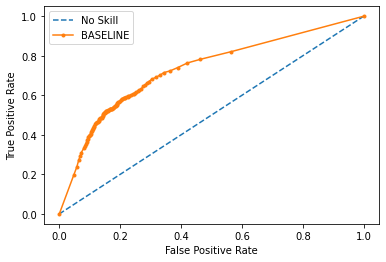

No Skill ROC AUC 0.494
Baseline ROC AUC 0.730
100
100


In [29]:
## ROC CURVE
testy = y_test2

# plot no skill roc curve
model = DummyClassifier(strategy='stratified')
model.fit(X_train, y_train2)
yhat = model.predict_proba(X_test)
pos_probs = yhat[:, 1]
roc_auc_noskill = roc_auc_score(testy, pos_probs)

pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# plot the skill curve
# retrieve just the probabilities for the positive class
pos_probs = pipeline.predict_proba(X_test)[:,1]
# calculate roc curve for model
fpr, tpr, _ = roc_curve(testy, pos_probs)

# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label=f'BASELINE')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()


roc_auc = roc_auc_score(testy, pos_probs)
print('No Skill ROC AUC %.3f' % roc_auc_noskill)
print('Baseline ROC AUC %.3f' % roc_auc)
print(len(fpr))
print(len(tpr))

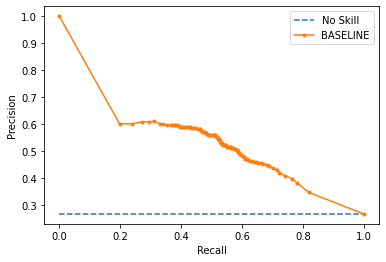

No Skill PR AUC: 0.371
Logistic PR AUC: 0.539
102
102


In [30]:
## PR Curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
y = y_test2
no_of_pos = len(y_test[y_test["vote"]=="Imod"])


# calculate the no skill line as the proportion of the positive class
no_skill = (no_of_pos / len(y))
# plot the no skill precision-recall curve
model = DummyClassifier(strategy='stratified')
model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, pos_probs)
auc_score_noskill = auc(recall, precision)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate model precision-recall curve
pos_probs = pipeline.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(testy, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label=f'BASELINE')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score_noskill)
print('Logistic PR AUC: %.3f' % auc_score)
print(len(recall))
print(len(precision))

##### Pred and KPIs per party

In [ ]:
df_KPI = pd.DataFrame(X_test["party2"])
df_KPI["y_test"]=y_test2
df_KPI["y_pred"]=y_pred2

for party in df_KPI["party2"].unique():
    print('',party,"- Precision:", round(precision_score(df_KPI[df_KPI["party2"]==party]["y_test"], df_KPI[df_KPI["party2"]==party]["y_pred"]),2),
            "\n",party,"- Recall:", round(recall_score(df_KPI[df_KPI["party2"]==party]["y_test"], df_KPI[df_KPI["party2"]==party]["y_pred"]),2),
            "\n",party,"- AUC:", round(roc_auc_score(df_KPI[df_KPI["party2"]==party]["y_test"], df_KPI[df_KPI["party2"]==party]["y_pred"]),2),
            "\n",party,"- F1:", round(f1_score(df_KPI[df_KPI["party2"]==party]["y_test"], df_KPI[df_KPI["party2"]==party]["y_pred"]),2),
            "\n**********************")

##### Pred and KPIs per politician

In [ ]:
top_climate_voters =['Hans Kristian Skibby',
 'Bent Bøgsted',
 'Bjarne Laustsen',
 'Erling Bonnesen',
 'Torsten Schack Pedersen',
 'Benny Engelbrecht',
 'Bertel Haarder',
 'Lars Christian Lilleholt',
 'Lennart Damsbo-Andersen',
 'Liselott Blixt',
 'Mette Gjerskov',
 'Jacob Jensen',
 'Jesper Petersen',
 'Julie Skovsby',
 'Louise Schack Elholm',
 'Orla Hav',
 'Thomas Jensen',
 'Kristian Pihl Lorentzen',
 'Mikkel Dencker',
 'Ellen Trane Nørby',
 'Karsten Lauritzen',
 'Hans Andersen',
 'Magnus Heunicke',
 'Rasmus Horn Langhoff',
 'Leif Lahn Jensen',
 'Jens Joel',
 'Dennis Flydtkjær',
 'Marie Krarup',
 'Troels Lund Poulsen',
 'Karen Ellemann',
 'Pia Adelsteen',
 'Rasmus Prehn',
 'Flemming Damgaard Larsen',
 'Kim Christiansen',
 'Jan E. Jørgensen',
 'Sophie Løhde',
 'Karin Nødgaard',
 'Trine Bramsen',
 'Karina Adsbøl',
 'Eyvind Vesselbo',
 'Hans Christian Schmidt',
 'Tom Behnke',
 'Ole Birk Olesen',
 'Michael Aastrup Jensen',
 'Birgitte Josefsen',
 'Anni Matthiesen',
 'Flemming Møller Mortensen',
 'Troels Ravn',
 'Preben Bang Henriksen',
 'Jens Henrik Thulesen Dahl',
 'Morten Bødskov',
 'Karen J. Klint',
 'René Christensen',
 'Kim Andersen',
 'Ib Poulsen',
 'Inger Støjberg',
 'Marianne Jelved',
 'Eva Kjer Hansen',
 'Annette Lind',
 'Jane Heitmann',
 'Peter Juel Jensen',
 'Daniel Toft Jakobsen',
 'Henrik Dahl',
 'Karsten Nonbo',
 'Jakob Sølvhøj',
 'Christian Juhl',
 'Jørn Dohrmann',
 'Kristian Jensen',
 'Jan Johansen',
 'Karsten Hønge',
 'Brian Mikkelsen',
 'Naser Khader',
 'Thomas Danielsen',
 'Martin Henriksen',
 'Søren Krarup',
 'Mette Hjermind Dencker',
 'Astrid Krag',
 'Holger K. Nielsen',
 'Karin Gaardsted',
 'Anita Knakkergaard',
 'Alex Ahrendtsen',
 'Per Clausen',
 'Kirsten Brosbøl',
 'Lotte Rod',
 'Steen Gade',
 'Hans Christian Thoning',
 'Ulla Tørnæs',
 'Martin Geertsen',
 'Henrik Brodersen',
 'Pernille Rosenkrantz-Theil',
 'Preben Rudiengaard',
 'Marcus Knuth',
 'Tina Petersen',
 'Tina Nedergaard',
 'Rasmus Helveg Petersen',
 'Mattias Tesfaye',
 'Nick Hækkerup',
 'Lars Aslan Rasmussen',
 'Zenia Stampe',
 'Ida Auken']

In [ ]:
df_KPI = pd.DataFrame(X_test["politician"])
df_KPI["y_test"]=y_test2
df_KPI["y_pred"]=y_pred2

df_pol_KPI = pd.DataFrame()
print(len(df_KPI["politician"].unique()))


In [ ]:
df_KPI = df_KPI[df_KPI["politician"].isin(top_climate_voters)]
print(len(top_climate_voters))
print(len(df_KPI["politician"].unique()))

In [ ]:

for politician in df_KPI["politician"].unique():
    try:
        temp = pd.DataFrame()
        temp["politician"] = [politician]
        temp["Accuracy"] = [accuracy_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])]
        temp["Precision"] = [precision_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])]
        temp["Recall"] = recall_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])
        temp["AUC"] = roc_auc_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])
        temp["F1"] = f1_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])
        df_pol_KPI = df_pol_KPI.append(temp)
    except:
        print("error", politician)
        temp = pd.DataFrame()
        temp["politician"] = [politician]
        temp["Accuracy"] = [accuracy_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])]
        temp["Precision"] = [precision_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])]
        temp["Recall"] = recall_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])
        #temp["AUC"] = roc_auc_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])
        temp["F1"] = f1_score(df_KPI[df_KPI["politician"]==politician]["y_test"], df_KPI[df_KPI["politician"]==politician]["y_pred"])
        df_pol_KPI = df_pol_KPI.append(temp)


In [ ]:
df_pol_KPI.describe()

In [ ]:
df_pol_KPI.hist()

##### Feature importance (ELI5)

In [ ]:
onehot_columns = list(pipeline.named_steps['Encode cats and scale'].named_transformers_['OneHot'].get_feature_names(input_features=["party2", "vote_caller2"]))
numeric_features_list = list(["w_for", "w_against", "cos_sim"])
numeric_features_list.extend(onehot_columns)
#numeric_features_list

In [ ]:
import eli5
eli5.explain_weights(pipeline.named_steps['classifier'], top=50, feature_names=[numeric_features_list])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
## Link: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
categorical_columns = ["politician"]
numerical_columns = ["w_for", "w_against", "cos_sim"]
ohe = pipeline.named_steps['Encode cats and scale'].named_transformers_['OneHot']
feature_names = ohe.get_feature_names_out(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = pipeline.named_steps["classifier"].feature_importances_
sorted_idx = tree_feature_importances.argsort()
sorted_idx = sorted_idx[:25]

In [ ]:

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()